In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import dhg
from dhg import Graph
from dhg.data import Cora
from dhg.models import GCN
from dhg.random import set_seed
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator

c:\Users\lolis\Documents\UNI\Kurser\master thesis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Graph(num_v=5, num_e=8)
([(0, 1), (2, 4), (1, 2), (3, 4), (0, 3), (1, 4), (0, 2), (1, 3)], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
tensor([[ 1.6476,  0.6701],
        [-0.3357,  0.7443],
        [-1.2093,  0.1211],
        [ 1.4440,  1.3965],
        [ 0.3301, -0.6340]])


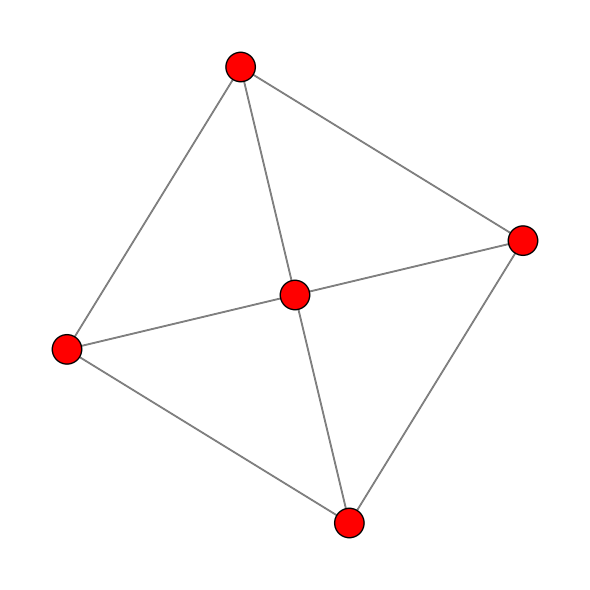

In [2]:
g = dhg.random.graph_Gnm(5, 8)
X = torch.randn(5, 2)
print(g)
print(g.e)
print(X)
g.draw()
plt.show()

In [3]:
X_ = g.v2v(X, aggr='mean')
print(X_)

tensor([[-0.0337,  0.7540],
        [ 0.5531,  0.3884],
        [ 0.5473,  0.2601],
        [ 0.5473,  0.2601],
        [-0.0337,  0.7540]])


In [4]:
X_ = g.v2v(X, aggr='sum')
print(X_)

tensor([[-0.1011,  2.2619],
        [ 2.2124,  1.5537],
        [ 1.6420,  0.7804],
        [ 1.6420,  0.7804],
        [-0.1011,  2.2619]])


In [5]:
e_weight = g.e_weight
X_ = g.v2v(X, e_weight=e_weight, aggr='softmax_then_sum')
print(X_)

tensor([[-0.0337,  0.7540],
        [ 0.5531,  0.3884],
        [ 0.5473,  0.2601],
        [ 0.5473,  0.2601],
        [-0.0337,  0.7540]])


Hypergraph(num_v=5, num_e=4)
([(0, 1), (0, 3), (2, 3, 4), (1, 4)], [1.0, 1.0, 1.0, 1.0])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])


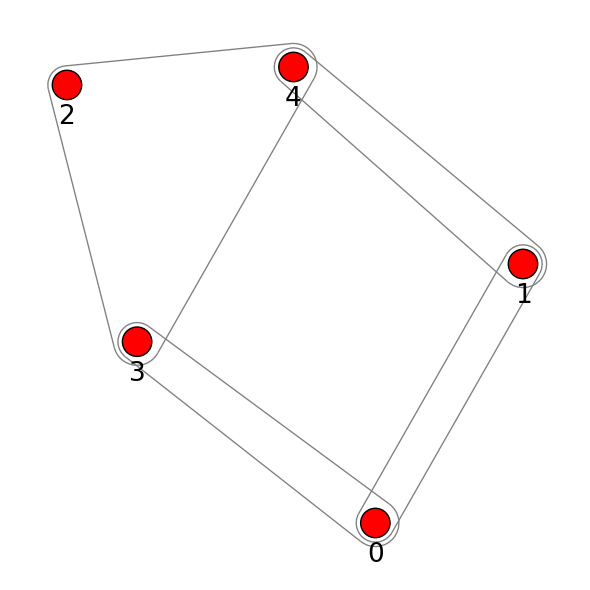

In [6]:
hg = dhg.random.hypergraph_Gnm(5, 4)
#X = torch.randn(5, 2)
X = torch.ones(5, 2)
print(hg)
print(hg.e)
print(X)
label = [0, 1, 2, 3, 4]
hg.draw(v_label=label)
plt.show()

In [7]:
X_ = hg.v2v(X, aggr='sum')
print(X_)

tensor([[4., 4.],
        [4., 4.],
        [3., 3.],
        [5., 5.],
        [5., 5.]])


In [26]:
def train(model, X, A, labels, train_mask, optimizer, criterion, epoch):
    model.train()

    optimizer.zero_grad()
    output = model(X, A)
    loss = criterion(output[train_mask], labels[train_mask])
    loss.backward()
    optimizer.step()

    print(f'Epoch: {epoch}, Loss: {loss.item()}')
    return loss.item()

In [27]:
set_seed(666)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
data = Cora()
X = data['features'].to(device)
labels = data['labels'].to(device)
G = Graph(data['num_vertices'], data['edge_list']).to(device)

model = GCN(data['dim_features'], 16, data['num_classes']).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = F.cross_entropy

best_model = deepcopy(model)
best_epoch = 0
best_score = 0.0
for epoch in range(100):
    loss = train(model, X, G, labels, data['train_mask'], optimizer, criterion, epoch)
    
    if epoch % 10:
        model.eval()
        with torch.no_grad():
            output = model(X, G)
            score = evaluator.validate(labels, output)
            if score > best_score:
                best_model = deepcopy(model)
                best_epoch = epoch
                best_score = score
                print(f'Epoch: {epoch}, Score: {score}')

print('\n Training Finished! \n')
print(f'Best Epoch: {best_epoch}, Best Score: {best_score}')

Epoch: 0, Loss: 1.9502947330474854
Epoch: 1, Loss: 1.945959448814392
Epoch: 1, Score: 0.08013293892145157
Epoch: 2, Loss: 1.9411373138427734
Epoch: 3, Loss: 1.9339078664779663
Epoch: 3, Score: 0.0805022120475769
Epoch: 4, Loss: 1.9298025369644165
Epoch: 4, Score: 0.08456425368785858
Epoch: 5, Loss: 1.9231538772583008
Epoch: 5, Score: 0.12186115235090256
Epoch: 6, Loss: 1.9172776937484741
Epoch: 6, Score: 0.19350074231624603
Epoch: 7, Loss: 1.9103838205337524
Epoch: 7, Score: 0.25997045636177063
Epoch: 8, Loss: 1.9034807682037354
Epoch: 8, Score: 0.31499260663986206
Epoch: 9, Loss: 1.895385503768921
Epoch: 9, Score: 0.3508124053478241
Epoch: 10, Loss: 1.8873751163482666
Epoch: 11, Loss: 1.8770784139633179
Epoch: 12, Loss: 1.867275357246399
Epoch: 13, Loss: 1.8582682609558105
Epoch: 14, Loss: 1.8510857820510864
Epoch: 15, Loss: 1.839239239692688
Epoch: 16, Loss: 1.830635905265808
Epoch: 17, Loss: 1.8206828832626343
Epoch: 17, Score: 0.36964550614356995
Epoch: 18, Loss: 1.8113402128219604